In [14]:
import argparse
from enum import Enum
import csv
from abc import ABC, abstractmethod
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Assume the given files are compiled by the ground truth (if the measured qubit is dark or bright)
BRIGHT_QUBITS_MEASUREMENTS = [
    'Data4Jens/BrightTimeTagSet1.csv',
    'Data4Jens/BrightTimeTagSet2.csv',
    'Data4Jens/BrightTimeTagSet3.csv',
    'Data4Jens/BrightTimeTagSet4.csv',
    'Data4Jens/BrightTimeTagSet5.csv',
]

DARK_QUBITS_MEASUREMENTS = [
    'Data4Jens/DarkTimeTagSet1.csv',
    'Data4Jens/DarkTimeTagSet2.csv',
    'Data4Jens/DarkTimeTagSet3.csv',
    'Data4Jens/DarkTimeTagSet4.csv',
    'Data4Jens/DarkTimeTagSet5.csv',
]

In [3]:
class Qubit(Enum):
    BRIGHT = 0
    DARK = 1


class QubitMeasurement():
    def __init__(self, photons, ground_truth):
        super().__init__()
        self.photons = photons
        self.ground_truth = ground_truth
        self.classified_result = None


class ClassificationModel(ABC):
    def __init__(self):
        super().__init__()
    
    @abstractmethod
    def classify(self, qubit_measurement):
        pass


class ThresholdCutoffModel(ClassificationModel):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def __str__(self):
        return "Threshold Cutoff Model w/ threshold {}".format(self.threshold)

    def classify(self, qubit_measurement):
        return Qubit.BRIGHT if len(qubit_measurement.photons) > self.threshold else Qubit.DARK

In [4]:
def get_arguments():
    parser = argparse.ArgumentParser()
    return parser.parse_args


def log(message):
    sys.stderr.write(message + '\n')


def read_qubit_measurements():
    def read_from_files_with_ground_truth(filenames, ground_truth, qubit_measurements):
        for measurement_filename in filenames:
            log("Loading {}".format(measurement_filename))
            with open(measurement_filename, 'r') as measurement_file:
                reader = csv.reader(measurement_file)
                for photons in reader:
                    qubit_measurements.append(QubitMeasurement([float(photon) for photon in photons], ground_truth))
        return qubit_measurements

    qubit_measurements = []
    read_from_files_with_ground_truth(BRIGHT_QUBITS_MEASUREMENTS, Qubit.BRIGHT, qubit_measurements)
    read_from_files_with_ground_truth(DARK_QUBITS_MEASUREMENTS, Qubit.DARK, qubit_measurements)
    return qubit_measurements


def classify_qubits(model, qubit_measurements):
    log("Classifying qubit measurements with {}".format(model))
    for measurement in qubit_measurements:
        measurement.classified_result = model.classify(measurement)
    return


def gather_measurement_statistics(qubit_measurements):
    datapoints = len(qubit_measurements)
    false_positives = len(list(filter(
        lambda measurement: measurement.ground_truth == Qubit.BRIGHT and measurement.classified_result == Qubit.DARK, 
        qubit_measurements)))
    false_negatives = len(list(filter(
        lambda measurement: measurement.ground_truth == Qubit.DARK and measurement.classified_result == Qubit.BRIGHT, 
        qubit_measurements)))
    reliability = 1 - (false_positives + false_negatives) / datapoints

    print("Datapoints: {}\nFalse Positives : {}\nFalse Negatives: {}\nReliability: {}".format(
        datapoints, false_positives, false_negatives, reliability))
    return reliability

In [5]:
def threshold_cutoff_experiments():
    options = get_arguments()
    qubit_measurements = read_qubit_measurements()

    _most_photons_received = max(list(map(lambda measurement: len(measurement.photons), qubit_measurements)))
    print("Max number of photons captured for one qubit: {}".format(_most_photons_received))

    _accuracy_results = []
    # try to classify measurements with a range of cutoff values and look at their accuracy
    for threshold in range(0, _most_photons_received + 1):
        model = ThresholdCutoffModel(threshold)
        classify_qubits(model, qubit_measurements)
        reliability = gather_measurement_statistics(qubit_measurements)
        _accuracy_results.append((threshold, reliability))
    
    print("Threshold Cutoff Model Accuracy:")
    for threshold, reliability in _accuracy_results:
        print("{},{}".format(threshold, reliability))

In [8]:
# find_false_classifications_with_photon_histogram
"""
Classify qubits by the Threshold Cutoff Model with the optimal threshold, find all mis-classified qubits and
print the histogram of each's measured photons (frequency of every arriving time interval)
"""
options= get_arguments()
qubit_measurements = read_qubit_measurements()
model = ThresholdCutoffModel(12)
classify_qubits(model, qubit_measurements)
reliability = gather_measurement_statistics(qubit_measurements)

Loading Data4Jens/BrightTimeTagSet1.csv
Loading Data4Jens/BrightTimeTagSet2.csv
Loading Data4Jens/BrightTimeTagSet3.csv
Loading Data4Jens/BrightTimeTagSet4.csv
Loading Data4Jens/BrightTimeTagSet5.csv
Loading Data4Jens/DarkTimeTagSet1.csv
Loading Data4Jens/DarkTimeTagSet2.csv
Loading Data4Jens/DarkTimeTagSet3.csv
Loading Data4Jens/DarkTimeTagSet4.csv
Loading Data4Jens/DarkTimeTagSet5.csv
Classifying qubit measurements with Threshold Cutoff Model w/ threshold 12


Datapoints: 387133
False Positives : 39
False Negatives: 74
Reliability: 0.9997081106493118


In [33]:
misclassified_qubits = list(filter(
    lambda measurement: measurement.ground_truth != measurement.classified_result, qubit_measurements))
false_positive_qubits = list(filter(
    lambda measurement: measurement.ground_truth == Qubit.BRIGHT and measurement.classified_result == Qubit.DARK, 
    qubit_measurements))
false_negative_qubits = list(filter(
    lambda measurement: measurement.ground_truth == Qubit.DARK and measurement.classified_result == Qubit.BRIGHT, 
    qubit_measurements))

print("A total of {} false positives and {} false negatives.".format(
    len(false_positive_qubits), len(false_negative_qubits)))
measurement_photon_histograms = [np.histogram(qubit.photons) for qubit in misclassified_qubits]
print("One historgram of measured photons in a mis-classifed qubit: \n{}".format(measurement_photon_histograms[0]))

A total of 39 false positives and 74 false negatives.
One historgram of measured photons in a mis-classifed qubit: 
(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), array([-0.49764103, -0.39764103, -0.29764103, -0.19764103, -0.09764103,
        0.00235897,  0.10235897,  0.20235897,  0.30235897,  0.40235897,
        0.50235897]))


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.49713096, -0.39713096, -0.29713096, -0.19713096, -0.09713096,
         0.00286904,  0.10286904,  0.20286904,  0.30286904,  0.40286904,
         0.50286904]),
 <a list of 10 Patch objects>)

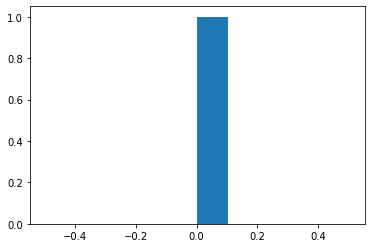

In [34]:
FALSE_POSITIVE_INDEX = 10
plt.hist(false_positive_qubits[FALSE_POSITIVE_INDEX].photons)

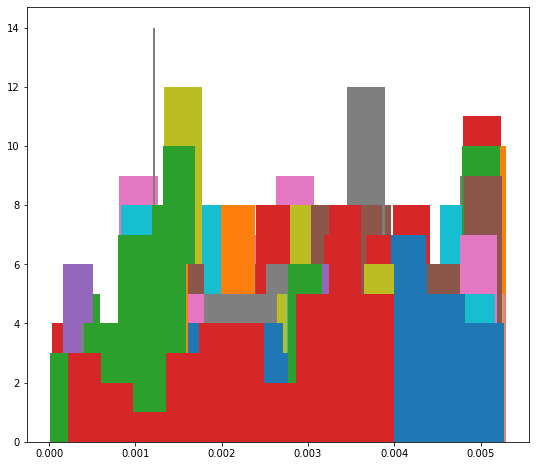

In [40]:
# FALSE_NEGATIVE_INDEX = 10
# plt.hist(false_negative_qubits[FALSE_NEGATIVE_INDEX].photons)

fig = plt.figure(figsize=(9, 8))
for index in range(len(false_negative_qubits)):
    plt.hist(false_negative_qubits[index].photons)